<a href="https://colab.research.google.com/github/yatingyy/DSCI551_project/blob/main/notebook/Yating_Yang_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yating_Yang_FinalProject**

## **1. Transfer Learning for Video Classification1**


In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install --upgrade tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
import zipfile
import shutil
import tensorflow as tf
from tensorflow import keras
import splitfolders
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback

(a)In this problem, we are trying to build a classifier that distinguishes videos of 5
different activities .

(b) **Video Classification** 

Videos can be viewed as a sequences of individual images; therefore, one can deal with video classification as performing image classification L times, where L is the number of frames in a video. However, this setting has a problem: it does not capture the temporal nature of the video. That is why we use RNN-CNN for video classification. Training RNN-CNN’s needs a lot of computational resources, and it might sometimes be excessive, so in this project we will take a simpler approach.

(c) **Moving Averages over Predictions for Video Classification**

In this approach, we train a CNN for image classification, and turn it into a video classifier using moving averages. If we rely on only one or a few frames of a video for classifying it, we will observe a phenomenon called flickering, which is assigning different labels to different frames of a video in the same class. However, if we use an average of predictions of probabilities for multiple frames, we will get a more reliable prediction for a video.

(d) **Data Exploration and Pre-processing**

i. Images in each class are given in separate folders in the folder Sport Images. We have several hundreds of images for five classes of sport activities, namely baseball, basketball, fencing, tennis, and volleyball.

In [5]:

drive.mount('/content/drive')
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/Data.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ii. Randomly select ⌈0.7ni⌉ images from each folder as your training set, ⌈0.15ni⌉ as validation set, and the rest as your test set, where ni is the number of images in folder i and ⌈x⌉ is the ceiling of x.


In [6]:
splitfolders.ratio('/tmp/Data/Sport Images',output='../data/imagespliter',seed = 7, ratio=(.7,.15,.15)
                   ,group_prefix=None, move=False)

Copying files: 3285 files [00:01, 1904.41 files/s]


iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [7]:
batch_size = 5
shutil.rmtree('/data/imagespliter/test/Image URLs')
shutil.rmtree('/data/imagespliter/train/Image URLs')
shutil.rmtree('/data/imagespliter/val/Image URLs')
train_df = tf.keras.utils.image_dataset_from_directory('../data/imagespliter/train', 
                             image_size = (224,224),  batch_size=batch_size, labels = 'inferred',label_mode = 'categorical')
test_df = tf.keras.utils.image_dataset_from_directory('../data/imagespliter/test', 
                             image_size = (224,224), batch_size=batch_size,labels = 'inferred',label_mode = 'categorical')
validate_df = tf.keras.utils.image_dataset_from_directory('../data/imagespliter/val', 
                             image_size = (224,224), labels = 'inferred',batch_size=batch_size, label_mode = 'categorical')


Found 2292 files belonging to 5 classes.
Found 497 files belonging to 5 classes.
Found 490 files belonging to 5 classes.



**(e) Transfer Learning for Image Classification3**

i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to ex- tract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only several hundred images per class. Given that we have 5 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models ResNet50, EfficientNetB0, and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, con- trast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  layers.RandomContrast(factor=0.1),
])

iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

iv. Train the networks ResNet50, EfficientNetB0, and VGG16 for at least 50 epochs (preferably 100 epochs) and perform early stopping using the valida- tion set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

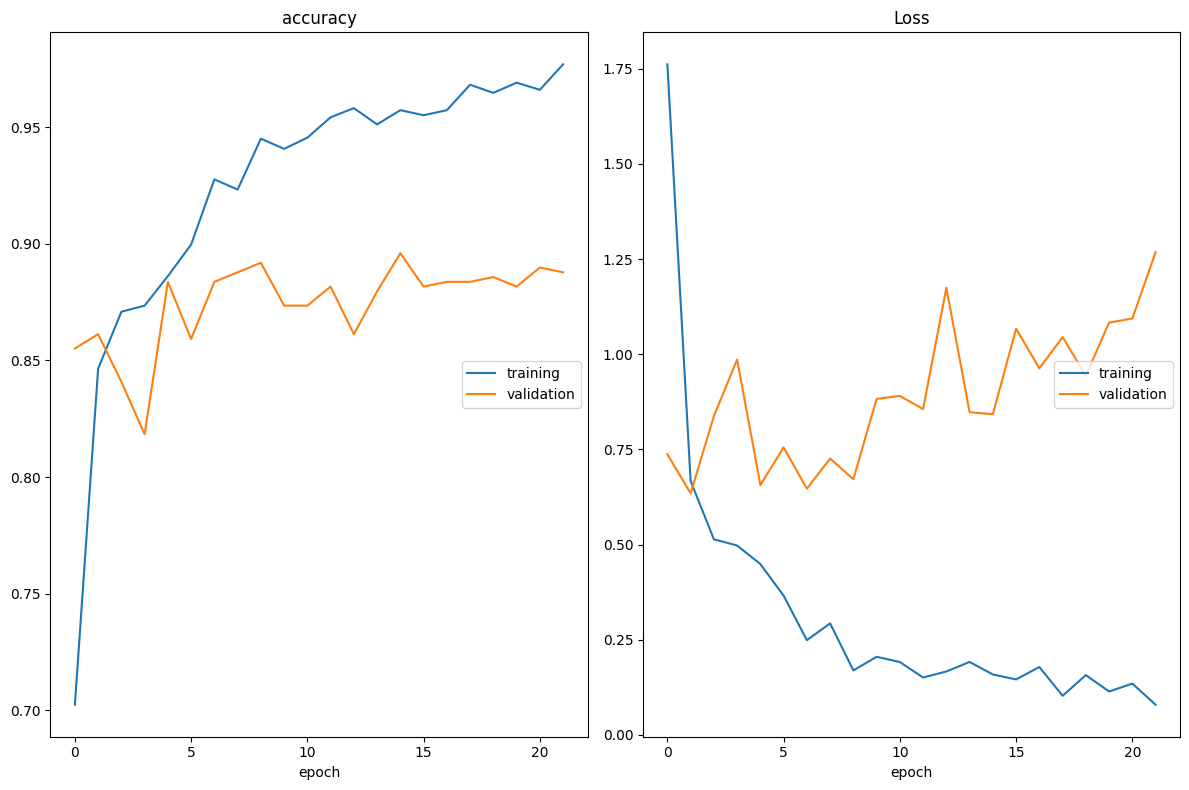

accuracy
	training         	 (min:    0.702, max:    0.977, cur:    0.977)
	validation       	 (min:    0.818, max:    0.896, cur:    0.888)
Loss
	training         	 (min:    0.079, max:    1.762, cur:    0.079)
	validation       	 (min:    0.635, max:    1.268, cur:    1.268)
100/100 [==============================] - 2s 12ms/step
ResNet50 Model Accuracy: 20.93%


In [9]:
inputs = keras.Input(shape=(224, 224, 3))
#Loading the ResNet50 model with pre-trained ImageNet weights
resnet = keras.applications.ResNet50(weights='imagenet',include_top=False,input_tensor=inputs)
resnet.trainable = False
x = data_augmentation(inputs)
n_classes = 5
x = resnet(x, training=False)
x = layers.GlobalAveragePooling2D(name="avg_pool")(resnet.output)
x = layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
layer_output = layers.Dense(1072, activation = 'relu')(x)
#x = layers.BatchNormalization()(x)
output = layers.Dense(n_classes, activation="softmax", name="pred")(layer_output)
model = tf.keras.Model(inputs, output)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
epochs = 50
batchsize = 5

plot_loss_1 = PlotLossesCallback()

checkpointer = keras.callbacks.ModelCheckpoint(filepath='/tmp/resnet_checkpoint.h5',
                                           monitor="val_accuracy", 
                                           verbose=1, 
                                           save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')
model.fit(train_df, batch_size=batchsize, epochs=epochs, callbacks=[checkpointer, early_stop, plot_loss_1], validation_data=validate_df)
model.save("/tmp/resnet_checkpoint.h5")

resnet_pred = model.predict(test_df, batch_size = batchsize)
resnet_pred_classes = np.argmax(resnet_pred, axis=1)
labels = np.array([])
for x, y in test_df:
  labels = np.concatenate([labels, np.argmax(y.numpy(),axis=-1)])

#from keras.preprocessing.image import ImageDataGenerator
#test_datagen = ImageDataGenerator(rescale=1./224)

#test_generator = test_datagen.flow_from_directory(
#        '../data/imagespliter/test',
#        target_size=(224, 224),
#        batch_size=2,
#        class_mode='categorical')
#labels = test_generator.classes
#true_classes = test_df.classes
resnet_acc = accuracy_score(labels, resnet_pred_classes)
print("ResNet50 Model Accuracy: {:.2f}%".format(resnet_acc * 100))

In [10]:
'''
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./224)

test_generator = test_datagen.flow_from_directory(
        '../data/imagespliter/test',
        target_size=(224, 224),
        batch_size=5,
        class_mode='categorical')
resnet_pred = model.predict(test_generator, batch_size = 5)
resnet_pred_classes = np.argmax(resnet_pred, axis=1)
labels = test_generator.classes
#true_classes = test_df.classes
resnet_acc = accuracy_score(labels, resnet_pred_classes)
print("ResNet50 Model Accuracy: {:.2f}%".format(resnet_acc * 100))'''

'\nfrom keras.preprocessing.image import ImageDataGenerator\ntest_datagen = ImageDataGenerator(rescale=1./224)\n\ntest_generator = test_datagen.flow_from_directory(\n        \'../data/imagespliter/test\',\n        target_size=(224, 224),\n        batch_size=5,\n        class_mode=\'categorical\')\nresnet_pred = model.predict(test_generator, batch_size = 5)\nresnet_pred_classes = np.argmax(resnet_pred, axis=1)\nlabels = test_generator.classes\n#true_classes = test_df.classes\nresnet_acc = accuracy_score(labels, resnet_pred_classes)\nprint("ResNet50 Model Accuracy: {:.2f}%".format(resnet_acc * 100))'

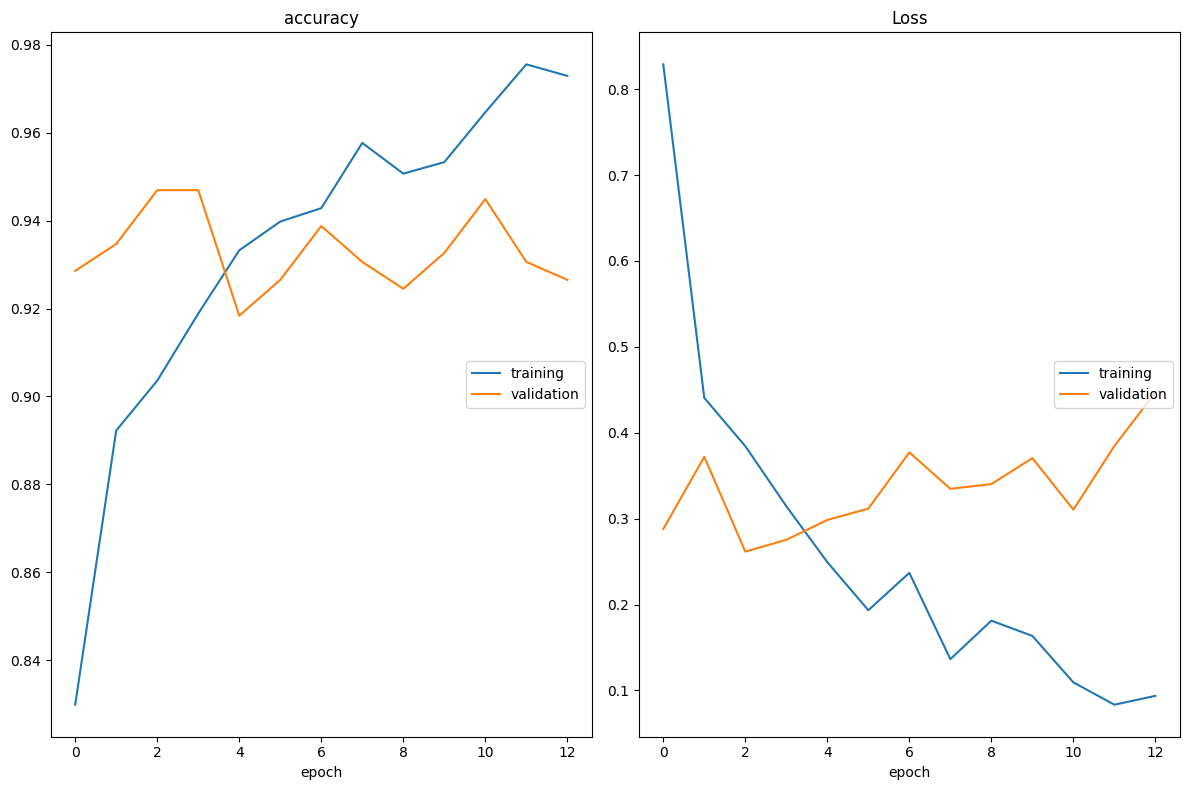

accuracy
	training         	 (min:    0.830, max:    0.976, cur:    0.973)
	validation       	 (min:    0.918, max:    0.947, cur:    0.927)
Loss
	training         	 (min:    0.083, max:    0.829, cur:    0.094)
	validation       	 (min:    0.262, max:    0.447, cur:    0.447)
100/100 [==============================] - 3s 14ms/step
EfficientNetB0 Model Accuracy: 21.73%


In [13]:
#EfficientNetB0
inputs = keras.Input(shape=(224, 224, 3))
efficientnet = keras.applications.EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
efficientnet.trainable = False
x = data_augmentation(inputs)
n_classes = 5
x = resnet(x, training=False)
x = layers.GlobalAveragePooling2D(name="avg_pool")(efficientnet.output)
x = layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
layer_output = layers.Dense(1072, activation = 'relu')(x)
output = layers.Dense(n_classes, activation="softmax", name="pred")(layer_output)
EN_model = tf.keras.Model(inputs, output, name="EfficientNet")

EN_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
epochs = 50
plot_loss_1 = PlotLossesCallback()
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/tmp/EN_checkpoint.h5',
                                           monitor="val_accuracy", 
                                           verbose=1, 
                                           save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
EN_model.fit(train_df, batch_size=5, epochs=epochs, callbacks=[checkpointer, early_stop,plot_loss_1], validation_data=validate_df)
EN_model.save("/tmp/EN_checkpoint.h5")

EN_pred = EN_model.predict(test_df, batch_size = 5)
EN_pred_classes = np.argmax(EN_pred, axis=1)
labels = np.array([])
for x, y in test_df:
  labels = np.concatenate([labels, np.argmax(y.numpy(),axis=-1)])
#true_classes = test_df.classes
EN_acc = accuracy_score(labels, EN_pred_classes)
print("EfficientNetB0 Model Accuracy: {:.2f}%".format(EN_acc * 100))

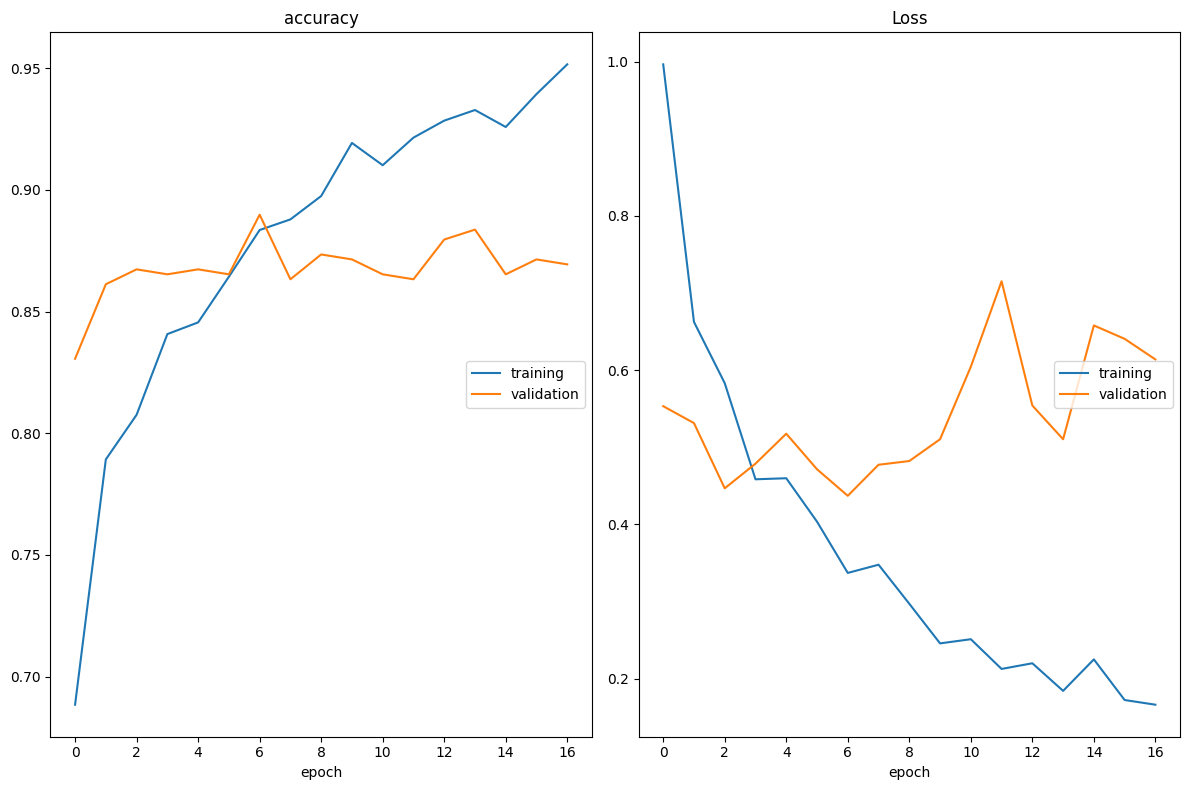

accuracy
	training         	 (min:    0.688, max:    0.952, cur:    0.952)
	validation       	 (min:    0.831, max:    0.890, cur:    0.869)
Loss
	training         	 (min:    0.166, max:    0.997, cur:    0.166)
	validation       	 (min:    0.437, max:    0.715, cur:    0.614)
100/100 [==============================] - 1s 12ms/step
VGG16 Model Accuracy: 23.14%


In [15]:
#VGG16
inputs = keras.Input(shape=(224, 224, 3))
vgg = keras.applications.VGG16(include_top=False, input_tensor=inputs, weights="imagenet")
vgg.trainable = False
x = data_augmentation(inputs)
n_classes = 5
x = resnet(x, training=False)
x = layers.GlobalAveragePooling2D(name="avg_pool")(vgg.output)
x = layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
layer_output = layers.Dense(1072, activation = 'relu')(x)
output = layers.Dense(n_classes, activation="softmax", name="pred")(layer_output)
VGG_model = tf.keras.Model(inputs, output, name="VGG16")

VGG_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
epochs = 50
plot_loss_1 = PlotLossesCallback()
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/tmp/VGG_checkpoint.h5',
                                           monitor="val_accuracy", 
                                           verbose=1, 
                                           save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
VGG_model.fit(train_df, batch_size=5, epochs=epochs, callbacks=[checkpointer, early_stop, plot_loss_1], validation_data=validate_df)
VGG_model.save("/tmp/VGG_checkpoint.h5")

VGG_pred = VGG_model.predict(test_df, batch_size = 5)
VGG_pred_classes = np.argmax(VGG_pred, axis=1)
labels = np.array([])
for x, y in test_df:
  labels = np.concatenate([labels, np.argmax(y.numpy(),axis=-1)])
#true_classes = test_df.classes
VGG_acc = accuracy_score(labels, VGG_pred_classes)
print("VGG16 Model Accuracy: {:.2f}%".format(VGG_acc * 100))


v. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for your model on both training and test sets. Remember that this is a multi-class classification problem.

In [31]:
labels_train = np.array([])
for x, y in train_df:
  labels_train = np.concatenate([labels_train, np.argmax(y.numpy(),axis=-1)])

labels = np.array([])
for x, y in test_df:
  labels = np.concatenate([labels, np.argmax(y.numpy(),axis=-1)])

resnet_pred_train = model.predict(train_df, batch_size = 5)
resnet_pred_train_classes = np.argmax(resnet_pred_train, axis=1)

EN_pred_train = EN_model.predict(train_df, batch_size = 5)
EN_pred_train_classes = np.argmax(EN_pred_train, axis=1)

VGG_pred_train = VGG_model.predict(train_df, batch_size = 5)
VGG_pred_train_classes = np.argmax(VGG_pred_train, axis=1)

459/459 [==============================] - 6s 12ms/step


Found 493 images belonging to 5 classes.


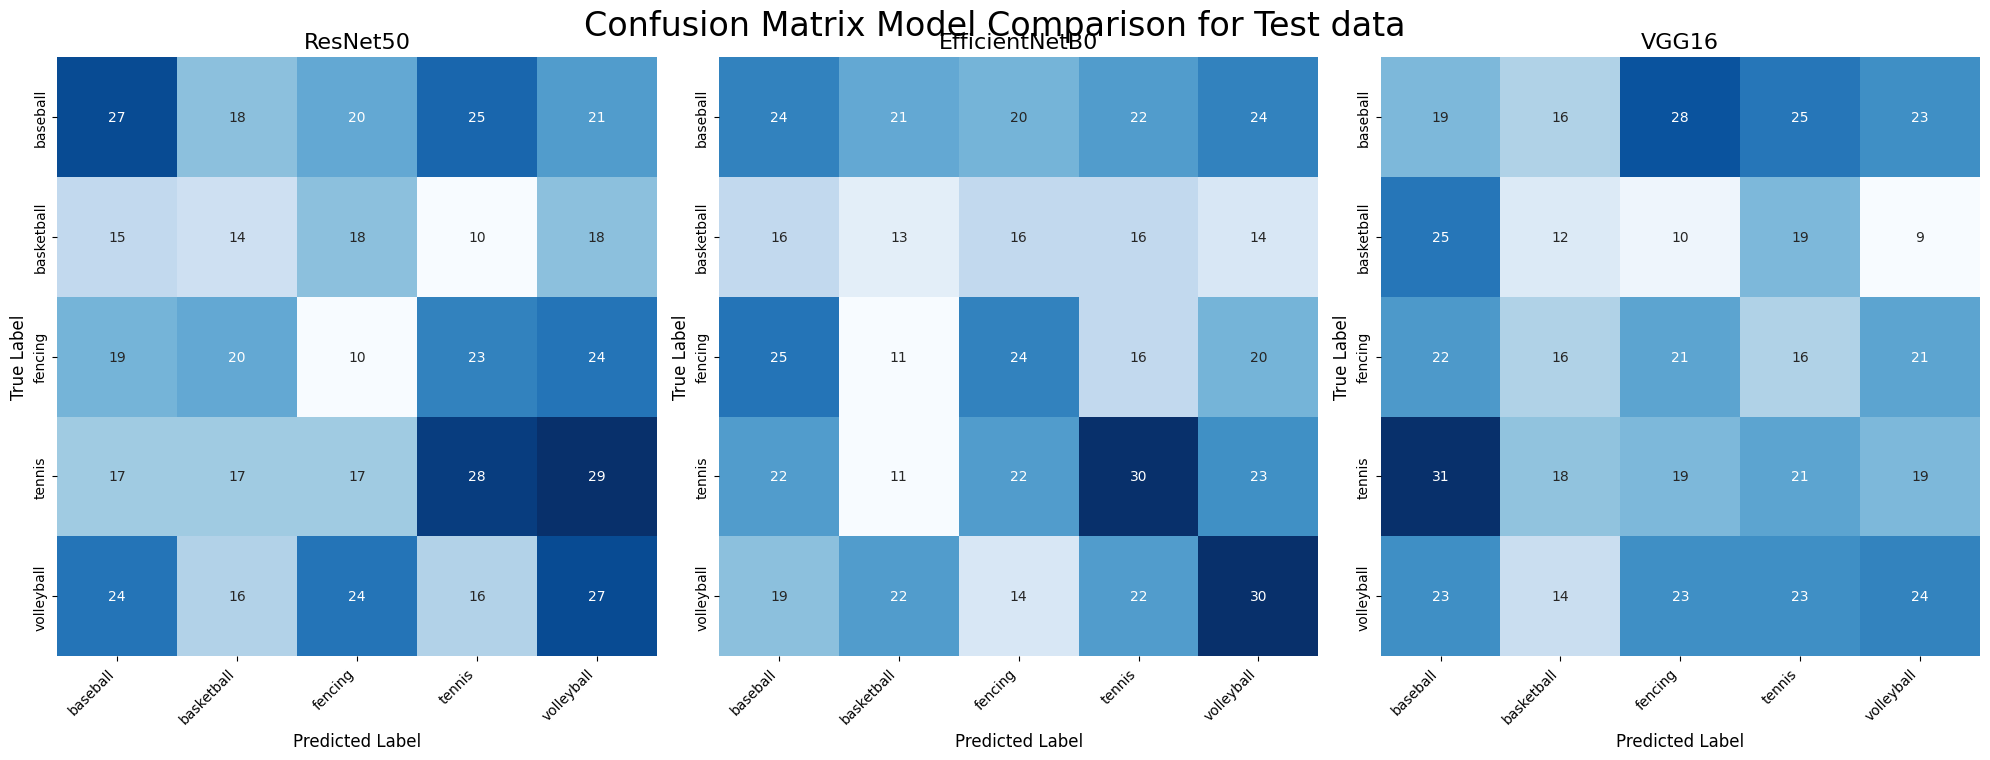

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./224)

test_generator = test_datagen.flow_from_directory(
        '../data/imagespliter/test',
        target_size=(224, 224),
        batch_size=5,
        class_mode='categorical')

class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(labels, resnet_pred_classes, class_names, ax1, title="ResNet50")    
plot_heatmap(labels, EN_pred_classes, class_names, ax2, title="EfficientNetB0")    
plot_heatmap(labels, VGG_pred_classes, class_names, ax3, title="VGG16")    

fig.suptitle("Confusion Matrix Model Comparison for Test data", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

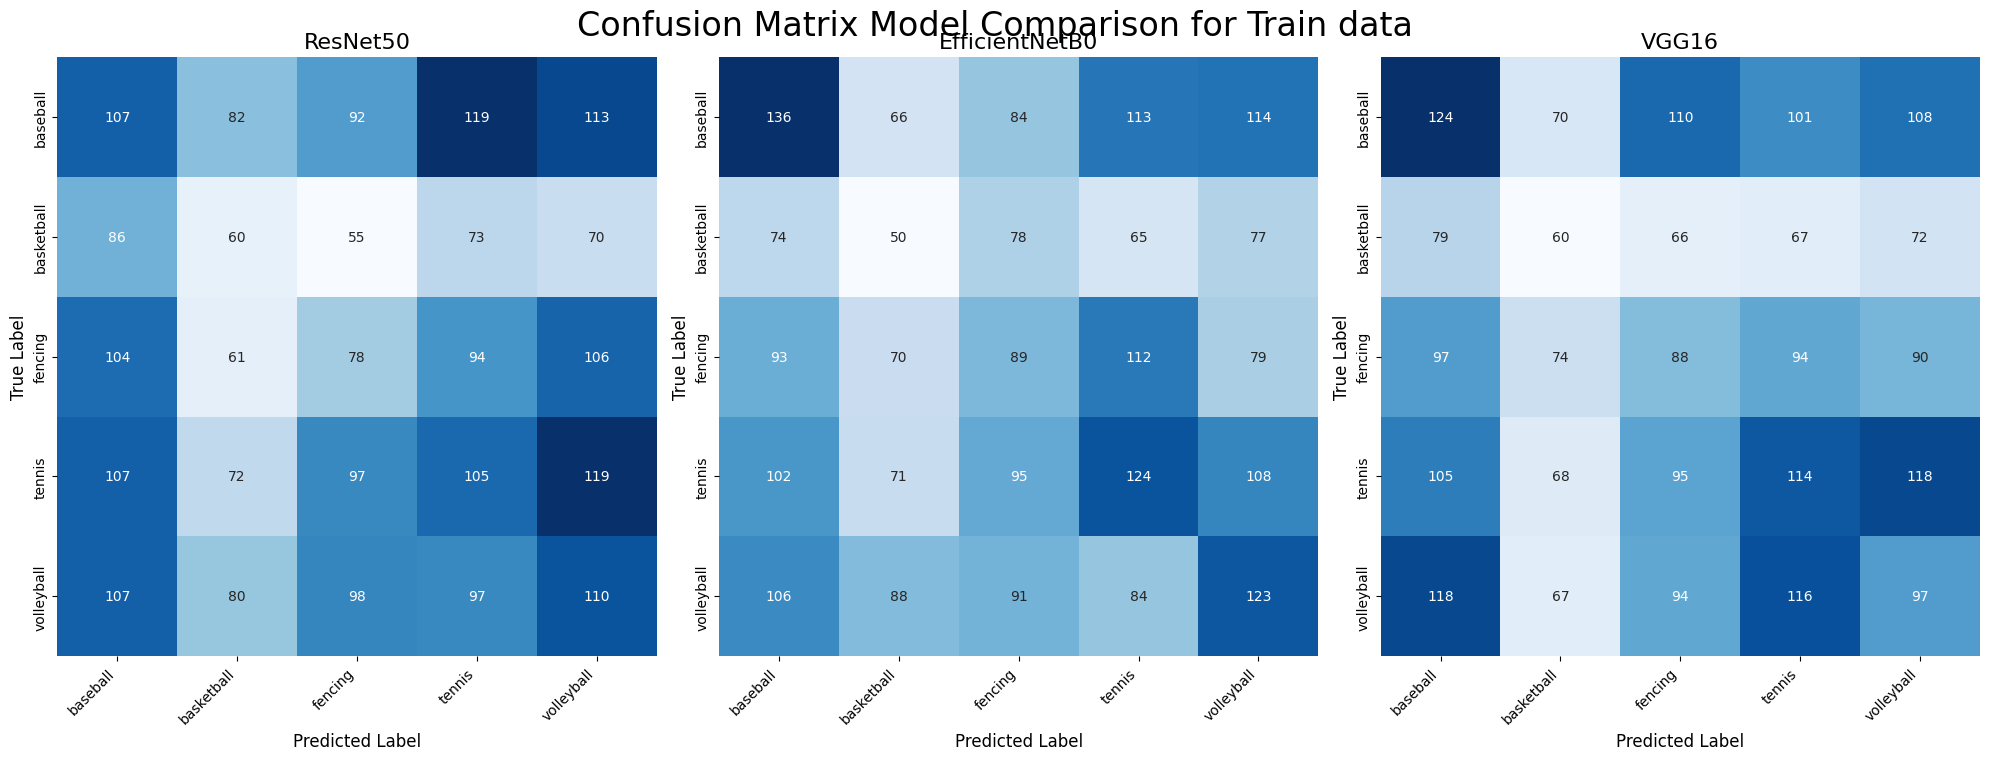

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(labels_train, resnet_pred_train_classes, class_names, ax1, title="ResNet50")    
plot_heatmap(labels_train, EN_pred_train_classes, class_names, ax2, title="EfficientNetB0")    
plot_heatmap(labels_train, VGG_pred_train_classes, class_names, ax3, title="VGG16")    

fig.suptitle("Confusion Matrix Model Comparison for Train data", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [35]:
#Precision, Recall, Accuracy, and F1 score
print("Classification report of Test data for ResNet50 model:")
print(classification_report(labels, resnet_pred_classes,target_names=class_names))

print("Classification report of Training data for ResNet50 model:")
print(classification_report(labels_train, resnet_pred_train_classes,target_names=class_names))

print("Classification report of Test data for EfficientNetB0 model:")
print(classification_report(labels, EN_pred_classes,target_names=class_names))

print("Classification report of Training data for EfficientNetB0 model:")
print(classification_report(labels_train, EN_pred_train_classes,target_names=class_names))

print("Classification report of Test data for VGG16 model:")
print(classification_report(labels, VGG_pred_classes,target_names=class_names))

print("Classification report of Training data for VGG16 model:")
print(classification_report(labels_train, VGG_pred_train_classes,target_names=class_names))

Classification report of Test data for ResNet50 model:
              precision    recall  f1-score   support

    baseball       0.26      0.24      0.25       111
  basketball       0.16      0.19      0.18        75
     fencing       0.11      0.10      0.11        96
      tennis       0.27      0.26      0.27       108
  volleyball       0.23      0.25      0.24       107

    accuracy                           0.21       497
   macro avg       0.21      0.21      0.21       497
weighted avg       0.21      0.21      0.21       497

Classification report of Training data for ResNet50 model:
              precision    recall  f1-score   support

    baseball       0.21      0.21      0.21       513
  basketball       0.17      0.17      0.17       344
     fencing       0.19      0.18      0.18       443
      tennis       0.22      0.21      0.21       500
  volleyball       0.21      0.22      0.22       492

    accuracy                           0.20      2292
   macro avg     